In [12]:
import pandas as pd
import numpy as np

In [13]:
df =  pd.read_csv("train.csv")

In [14]:
df.shape

(24236806, 10)

In [15]:
from datetime import datetime
df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
df = df.sort_values('date')
groups = pd.factorize(df['date'].dt.day.astype(str) + '_' + df['date'].dt.month.astype(str) + '_' + df['date'].dt.year.astype(str))[0]

In [16]:
btc = df[df["Asset_ID"]==1].set_index("date")

In [17]:
import plotly.graph_objects as go
btc_mini = btc.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

In [18]:
import pickle as pkl
pickle_out = open("btc_mini.pkl","wb")
pkl.dump(btc_mini,pickle_out)
pickle_out.close()

In [19]:
btc.fillna(method="ffill",axis=0, inplace=True)

In [20]:
btc.drop(columns=['timestamp','Asset_ID','Target','Volume'],axis=1,inplace=True)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
btc[['Count', 'Open', 'High', 'Low', 'Close', 'VWAP']]=scaler.fit_transform(btc[['Count', 'Open', 'High', 'Low', 'Close', 'VWAP']])

In [24]:
y = btc['Close']
X = btc.drop(columns=['Close'],axis=1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20,random_state=0)

In [26]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [27]:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [29]:
X_train.shape

(1565025, 5, 1)

In [30]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,activation='relu',input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train,y_train,verbose=1,epochs=10,batch_size=128)

Epoch 1/10
12227/12227 [==============================] - 127s 10ms/step - loss: 1.6308e-04
Epoch 2/10
12227/12227 [==============================] - 137s 11ms/step - loss: 1.6061e-06
Epoch 3/10
12227/12227 [==============================] - 153s 12ms/step - loss: 1.2095e-06
Epoch 4/10
12227/12227 [==============================] - 128s 11ms/step - loss: 1.0005e-06
Epoch 5/10
12227/12227 [==============================] - 134s 11ms/step - loss: 9.0131e-07
Epoch 6/10
12227/12227 [==============================] - 149s 12ms/step - loss: 7.4179e-07
Epoch 7/10
12227/12227 [==============================] - 133s 11ms/step - loss: 7.2587e-07
Epoch 8/10
12227/12227 [==============================] - 141s 11ms/step - loss: 6.5959e-07
Epoch 9/10
12227/12227 [==============================] - 132s 11ms/step - loss: 5.7966e-07
Epoch 10/10
12227/12227 [==============================] - 139s 11ms/step - loss: 5.3343e-07


<AxesSubplot:>

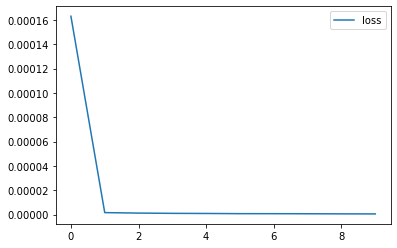

In [33]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [34]:
model.save("btc.h5")

In [35]:
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_test = np.array(y_test)

In [36]:
X_test.shape

(391257, 5, 1)

In [37]:
y_test = y_test.reshape(391257,1)

In [38]:
X_test[0].shape

(5, 1)

In [39]:
pred=model.predict(X_test)
#pred=scaler.inverse_transform(pred)
pred

array([[0.50759345],
       [0.0740772 ],
       [0.01259525],
       ...,
       [0.96171314],
       [0.08548193],
       [0.10736696]], dtype=float32)

In [40]:
pred.shape

(391257, 1)

In [41]:
rmse=np.sqrt(np.mean(((pred-y_test)**2)))
rmse

0.0003882518683694214